In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import math
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'ML_project'
FILENAME1 = 'sub-01_VoxelResponses.h5'
FILENAME2 = 'sub-01_Voxel_ROI_Mapping.csv'

# Navigate to the correct folder
%cd /content/drive/My\ Drive/$FOLDERNAME

# Copy both files to the working directory
%cp $FILENAME1 /content/
%cp $FILENAME2 /content/

# Navigate back to the working directory
%cd /content/

Mounted at /content/drive
/content/drive/My Drive/ML_project
/content


In [5]:
# Import the library to mount Google Drive
from google.colab import drive
import h5py


#Load the  file into a cuDF DataFrame
hdf5_file = f'/content/drive/My Drive/ML_project/{FILENAME1}'

# Open and inspect
with h5py.File(hdf5_file, "r") as h5f:
    print(" Datasets available:", list(h5f.keys()))

    # Check shapes of all datasets
    for name in h5f.keys():
        print(f"{name}: shape = {h5f[name].shape}, dtype = {h5f[name].dtype}")

    # Load a few samples
    stimulus_names = h5f["stimulus_names"][:5].astype(str)
    voxel_responses = h5f["voxel_responses"][:5, :10]  # first 5 stimuli, first 10 voxels

    print(" Stimulus Names:", stimulus_names)
    print(" Voxel responses (first 5 x 10):\n", voxel_responses)

roi_mapping_csv = "/content/sub-01_Voxel_ROI_Mapping.csv"

#  Load ROI mapping
roi_df = pd.read_csv(roi_mapping_csv)
roi_df['ROIs'] = roi_df['ROIs'].apply(lambda x: [r.strip() for r in x.split(',')])  # split multi-ROI fields
# Visual ROIs (labels must match column names in your df)
visual_rois = [
    "Left Lateral Occipital Complex",
    "Right Lateral Occipital Complex",
    "Left Fusiform Face Area",
    "Right Fusiform Face Area",
    "Left Parahippocampal Place Area",
    "Right Parahippocampal Place Area",
    "Left Extrastriate Body Area",
    "Right Extrastriate Body Area",
    "Inferotemporal Cortex"
]

# Memory ROIs
memory_rois = [
    "Parahippocampal Area 1",
    "Parahippocampal Area 2",
    "Parahippocampal Area 3",
    "Entorhinal Cortex",
    "Presubiculum",
    "Hippocampus",
    "Prosubiculum",
    "Perirhinal Cortex",
    "Retrosplenial Cortex",
    "Left Retrosplenial Cortex",
    "Right Retrosplenial Cortex",
    "Subgenual Cortex",
    "Superior Anterior Cingulate Cortex",
    "Posterior Orbitofrontal Cortex",
    "Right Anterior Prefrontal Cortex",
    "Ventral Anterior Prefrontal Cortex",
    "Medial Prefrontal Cortex",
    "Dorsolateral Prefrontal Cortex",
    "Dorsomedial Prefrontal Cortex"
]


# Load HDF5 voxel and metadata
with h5py.File(hdf5_file, "r") as h5f:
    stimulus_names = h5f["stimulus_names"][:].astype(str)
    concepts = h5f["concepts"][:].astype(str)
    memorability_scores = h5f["memorability_scores"][:]
    category_labels = h5f["category_labels"][:].astype(str)
    voxel_responses = h5f["voxel_responses"][:]  # shape (8740, 13295)
    voxel_ids_all = h5f["voxel_ids"][:].astype(int)  # Load saved voxel IDs
    voxel_id_to_index = {vid: i for i, vid in enumerate(voxel_ids_all)}  # Map to index

#  Create base DataFrame
df = pd.DataFrame({
    "stimulus_name": stimulus_names,
    "concept": concepts,
    "memorability_score": memorability_scores,
    "category_label": category_labels
})

#  Check shape before filtering
print("Shape before filtering:", df.shape)

# Filter invalid rows
df_filtered = df[
    df["memorability_score"].notna() &
    df["category_label"].notna() &
    (df["category_label"].str.lower() != "nan")
].copy()

# Filter valid rows
valid_mask = (
    df["memorability_score"].notna() &
    df["category_label"].notna() &
    (df["category_label"].str.lower() != "nan")
)
df_filtered = df[valid_mask].copy()
voxel_responses_filtered = voxel_responses[valid_mask.values, :]
print("Filtered rows:", df_filtered.shape[0])

# Extract unique ROIs
unique_rois = sorted({roi for roi_list in roi_df['ROIs'] for roi in roi_list})

# Map ROI → voxel indices
num_voxels = voxel_responses.shape[1]
roi_to_voxels = {}
for roi in unique_rois:
    voxel_ids_raw = roi_df[roi_df['ROIs'].apply(lambda rois: roi in rois)]['Voxel ID'].values
    voxel_indices = [voxel_id_to_index[vid] for vid in voxel_ids_raw if vid in voxel_id_to_index]
    roi_to_voxels[roi] = voxel_indices


# Get the actual voxel IDs used (after filtering)
voxel_ids_filtered = voxel_ids_all  # these match voxel_responses_filtered columns

# Step 2: Add per-ROI mean columns to df_filtered
for roi, voxel_ids in roi_to_voxels.items():
    if len(voxel_ids) > 0:
        roi_mean = voxel_responses_filtered[:, voxel_ids].mean(axis=1)
        df_filtered[roi] = roi_mean
    else:
        df_filtered[roi] = np.nan
# Compute group-level mean activations (across unique voxel sets)
visual_voxels = sorted(set(vid for roi in visual_rois for vid in roi_to_voxels.get(roi, [])))
memory_voxels = sorted(set(vid for roi in memory_rois for vid in roi_to_voxels.get(roi, [])))
all_voxels = sorted(set(vid for roi in unique_rois for vid in roi_to_voxels.get(roi, [])))

df_filtered["AllVoxelsMean"] = voxel_responses_filtered[:, all_voxels].mean(axis=1)
df_filtered["mean_visual_activation"] = voxel_responses_filtered[:, visual_voxels].mean(axis=1)
df_filtered["mean_memory_activation"] = voxel_responses_filtered[:, memory_voxels].mean(axis=1)



#---- FOR ML MODELS -----
# Create column names using voxel IDs
voxel_columns = [f"voxel_{vid}" for vid in voxel_ids_filtered]

#Combine metadata with raw voxel responses using voxel ID names
df_voxel_expanded = pd.concat([
    df_filtered[["stimulus_name", "concept", "category_label", "memorability_score"]].reset_index(drop=True),
    pd.DataFrame(voxel_responses_filtered, columns=voxel_columns)
], axis=1)

display(df_voxel_expanded)

 Datasets available: ['category_labels', 'concepts', 'memorability_scores', 'stimulus_names', 'voxel_ids', 'voxel_responses']
category_labels: shape = (8740,), dtype = object
concepts: shape = (8740,), dtype = object
memorability_scores: shape = (8740,), dtype = float32
stimulus_names: shape = (8740,), dtype = object
voxel_ids: shape = (13295,), dtype = float64
voxel_responses: shape = (8740, 13295), dtype = float32
 Stimulus Names: ['acorn_01b.jpg' 'acorn_02n.jpg' 'acorn_03s.jpg' 'acorn_04s.jpg'
 'acorn_05s.jpg']
 Voxel responses (first 5 x 10):
 [[ 0.02257798  0.0513297  -0.05128353 -0.01974918  0.0332503   0.08136833
  -0.05810169 -0.01448982  0.00493409  0.05257775]
 [-0.03404223  0.10509922  0.04145947  0.01265379  0.04401546  0.05151408
   0.10634485  0.056573    0.12643212  0.03686157]
 [ 0.00750898  0.03320898  0.05258245 -0.01822083  0.02388836  0.05476559
   0.03924497  0.00077226 -0.06006511  0.08503772]
 [ 0.02669906 -0.10855836 -0.00228299 -0.17988689  0.01014542 -0.139118

stimulus_name   concept category_label  memorability_score  \
0       airbag_01b.jpg    airbag    part of car            0.800000   
1       airbag_02s.jpg    airbag    part of car            0.925000   
2       airbag_03s.jpg    airbag    part of car            0.743590   
3       airbag_04s.jpg    airbag    part of car            0.850000   
4       airbag_05s.jpg    airbag    part of car            0.904762   
...                ...       ...            ...                 ...   
6512  zucchini_08n.jpg  zucchini           food            0.871795   
6513  zucchini_09s.jpg  zucchini           food            0.809524   
6514  zucchini_10s.jpg  zucchini           food            0.790698   
6515  zucchini_11s.jpg  zucchini           food            0.772727   
6516  zucchini_12s.jpg  zucchini           food            0.846154   

      voxel_7884  voxel_7885  voxel_7899  voxel_7900  voxel_7901  voxel_7919  \
0       0.120756    0.047469   -0.012079    0.122661    0.091893    0.147065   
1       0.052944    0.045229    0.007861   -0.041738    0.013010   -0.047842   
2      -0.064389    0.073056   -0.116064    0.022430    0.084626    0.002893   
3      -0.083718   -0.060718    0.025261   -0.052589   -0.035440   -0.011761   
4       0.049381    0.132526    0.032189    0.184989    0.197687    0.060577   
...          ...         ...         ...         ...         ...         ...   
6512   -0.047824   -0.037500   -0.069483    0.081542   -0.079845    0.048797   
6513    0.073561    0.171627    0.090361    0.188699    0.192914    0.054675   
6514   -0.041272   -0.077850   -0.101745   -0.151866   -0.122934   -0.041501   
6515   -0.000802   -0.024950    0.023981    0.013377    0.050581    0.052937   
6516   -0.003731    0.070587    0.036252    0.048199    0.094610    0.033904   

      ...  voxel_201412  voxel_201413  voxel_201414  voxel_201415  \
0     ...     -0.064329      0.015379     -0.081447      0.005741   
1     ...      0.000795      0.031736      0.031305     -0.012461   
2     ...      0.037089     -0.050850     -0.012266     -0.030976   
3     ...     -0.002380     -0.010125      0.038258     -0.007189   
4     ...      0.062314      0.086618      0.234431     -0.017305   
...   ...           ...           ...           ...           ...   
6512  ...      0.077369      0.048833      0.022854     -0.098497   
6513  ...      0.116248      0.078620     -0.015562     -0.041244   
6514  ...     -0.124700     -0.128595     -0.178983     -0.043936   
6515  ...     -0.120898     -0.104700     -0.091134     -0.014936   
6516  ...      0.029545      0.024873     -0.010482      0.006838   

      voxel_201435  voxel_201436  voxel_201437  voxel_201438  voxel_201439  \
0         0.185713      0.094303     -0.043856      0.049301     -0.014260   
1         0.054059      0.087761      0.055621      0.091177      0.123287   
2        -0.035536      0.046730      0.028577     -0.020299      0.043931   
3        -0.008918      0.059566      0.043605     -0.016583     -0.038874   
4         0.086029      0.156870      0.130182      0.117288      0.211472   
...            ...           ...           ...           ...           ...   
6512     -0.102770     -0.053966      0.007080      0.002011      0.017467   
6513      0.163441      0.275017      0.033110      0.146085      0.131666   
6514     -0.041262     -0.095953     -0.147868     -0.081745     -0.105974   
6515      0.070211      0.019274     -0.098725     -0.110354     -0.057408   
6516      0.017920      0.036720     -0.019841      0.027043      0.008002   

      voxel_201440  
0         0.187444  
1        -0.055984  
2         0.024152  
3        -0.042213  
4         0.044470  
...            ...  
6512     -0.088687  
6513     -0.019307  
6514      0.049094  
6515     -0.074987  
6516      0.042661  

[6517 rows x 13299 columns]

In [ ]:
# Base columns you probably want to keep
base_columns = ["stimulus_name", "concept", "memorability_score", "category_label"]

# Visual ROI columns
visual_roi_columns = [roi for roi in visual_rois if roi in df_filtered.columns]
# Memory ROI columns that actually exist in the DataFrame
memory_roi_columns = [roi for roi in memory_rois if roi in df_filtered.columns]

# Combine base + visual ROI columns
columns_to_keep_visual = base_columns + visual_roi_columns
columns_to_keep_memory = base_columns + memory_roi_columns

# Create the visual-only DataFrame
df_visual_only = df_filtered[columns_to_keep_visual]
df_memory_only = df_filtered[columns_to_keep_memory]

display(df_visual_only)
display(df_memory_only)

stimulus_name   concept  memorability_score category_label  \
12      airbag_01b.jpg    airbag            0.800000    part of car   
13      airbag_02s.jpg    airbag            0.925000    part of car   
14      airbag_03s.jpg    airbag            0.743590    part of car   
15      airbag_04s.jpg    airbag            0.850000    part of car   
16      airbag_05s.jpg    airbag            0.904762    part of car   
...                ...       ...                 ...            ...   
8735  zucchini_08n.jpg  zucchini            0.871795           food   
8736  zucchini_09s.jpg  zucchini            0.809524           food   
8737  zucchini_10s.jpg  zucchini            0.790698           food   
8738  zucchini_11s.jpg  zucchini            0.772727           food   
8739  zucchini_12s.jpg  zucchini            0.846154           food   

      Left Lateral Occipital Complex  Right Lateral Occipital Complex  \
12                          0.007920                         0.017488   
13                          0.009496                         0.001079   
14                          0.009516                         0.002849   
15                          0.025253                         0.026926   
16                          0.045148                         0.028731   
...                              ...                              ...   
8735                       -0.010575                        -0.017455   
8736                        0.031495                         0.039695   
8737                        0.003662                        -0.006962   
8738                        0.034293                         0.031655   
8739                        0.011183                         0.006416   

      Left Fusiform Face Area  Right Fusiform Face Area  \
12                  -0.008078                  0.005624   
13                   0.002416                 -0.012641   
14                  -0.009196                  0.002296   
15                   0.009345                  0.016904   
16                   0.004447                  0.022834   
...                       ...                       ...   
8735                -0.015362                 -0.013483   
8736                 0.001326                  0.016158   
8737                -0.016464                 -0.009224   
8738                 0.008372                  0.011155   
8739                 0.000802                  0.000904   

      Left Parahippocampal Place Area  Right Parahippocampal Place Area  \
12                           0.007264                          0.004581   
13                           0.006293                          0.004173   
14                           0.006059                          0.012890   
15                           0.005285                          0.011164   
16                           0.041474                          0.030150   
...                               ...                               ...   
8735                        -0.008920                         -0.011059   
8736                         0.020616                          0.016235   
8737                         0.009221                          0.009855   
8738                         0.005308                          0.006105   
8739                        -0.005883                         -0.001156   

      Left Extrastriate Body Area  Right Extrastriate Body Area  \
12                       0.007092                      0.020563   
13                      -0.014296                      0.000873   
14                      -0.009302                     -0.006165   
15                       0.000117                      0.012186   
16                       0.050487                      0.043912   
...                           ...                           ...   
8735                    -0.030490                     -0.019471   
8736                     0.046513                      0.051844   
8737                    -0.006142                     -0.008627   

stimulus_name   concept  memorability_score category_label  \
12      airbag_01b.jpg    airbag            0.800000    part of car   
13      airbag_02s.jpg    airbag            0.925000    part of car   
14      airbag_03s.jpg    airbag            0.743590    part of car   
15      airbag_04s.jpg    airbag            0.850000    part of car   
16      airbag_05s.jpg    airbag            0.904762    part of car   
...                ...       ...                 ...            ...   
8735  zucchini_08n.jpg  zucchini            0.871795           food   
8736  zucchini_09s.jpg  zucchini            0.809524           food   
8737  zucchini_10s.jpg  zucchini            0.790698           food   
8738  zucchini_11s.jpg  zucchini            0.772727           food   
8739  zucchini_12s.jpg  zucchini            0.846154           food   

      Parahippocampal Area 1  Parahippocampal Area 2  Parahippocampal Area 3  \
12                  0.000598                0.004272                0.010367   
13                 -0.000139                0.021877                0.008371   
14                 -0.003408                0.010989                0.000262   
15                  0.000815                0.012673                0.012404   
16                  0.009711                0.032150                0.030329   
...                      ...                     ...                     ...   
8735                0.000063               -0.011938               -0.005073   
8736               -0.001506                0.005231                0.012154   
8737                0.003233               -0.000154               -0.006967   
8738               -0.001347                0.026701                0.025920   
8739                0.001841                0.002993               -0.010073   

      Entorhinal Cortex  Presubiculum  Hippocampus  ...  \
12            -0.000028     -0.001761     0.001977  ...   
13            -0.010245     -0.006459    -0.015249  ...   
14            -0.010679     -0.006262    -0.003854  ...   
15             0.007683      0.006487     0.003034  ...   
16             0.010516      0.012028     0.008050  ...   
...                 ...           ...          ...  ...   
8735          -0.000012     -0.005686    -0.014370  ...   
8736          -0.003815     -0.007543    -0.007431  ...   
8737           0.002631      0.006538     0.004437  ...   
8738           0.012338      0.002949     0.006670  ...   
8739          -0.001743     -0.004558    -0.016235  ...   

      Left Retrosplenial Cortex  Right Retrosplenial Cortex  Subgenual Cortex  \
12                    -0.005722                   -0.005105         -0.003121   
13                    -0.004472                   -0.012329          0.002407   
14                    -0.012610                   -0.008475         -0.018879   
15                     0.007228                    0.003518          0.012137   
16                     0.041506                    0.045590          0.005405   
...                         ...                         ...               ...   
8735                  -0.005198                    0.007377          0.000298   
8736                   0.015532                    0.020702         -0.015604   
8737                   0.004714                    0.005762         -0.002238   
8738                  -0.000580                    0.001402          0.019191   
8739                  -0.018305                   -0.009924         -0.005336   

      Superior Anterior Cingulate Cortex  Posterior Orbitofrontal Cortex  \
12                             -0.018571                       -0.004123   
13                              0.010056                       -0.013253   
14                             -0.025226                        0.003128   
15                              0.014588                        0.003562   
16                             -0.000581                        0.009665   
...                                  ...                 

#Scatter plot for the total fMRI response vs. memorability score

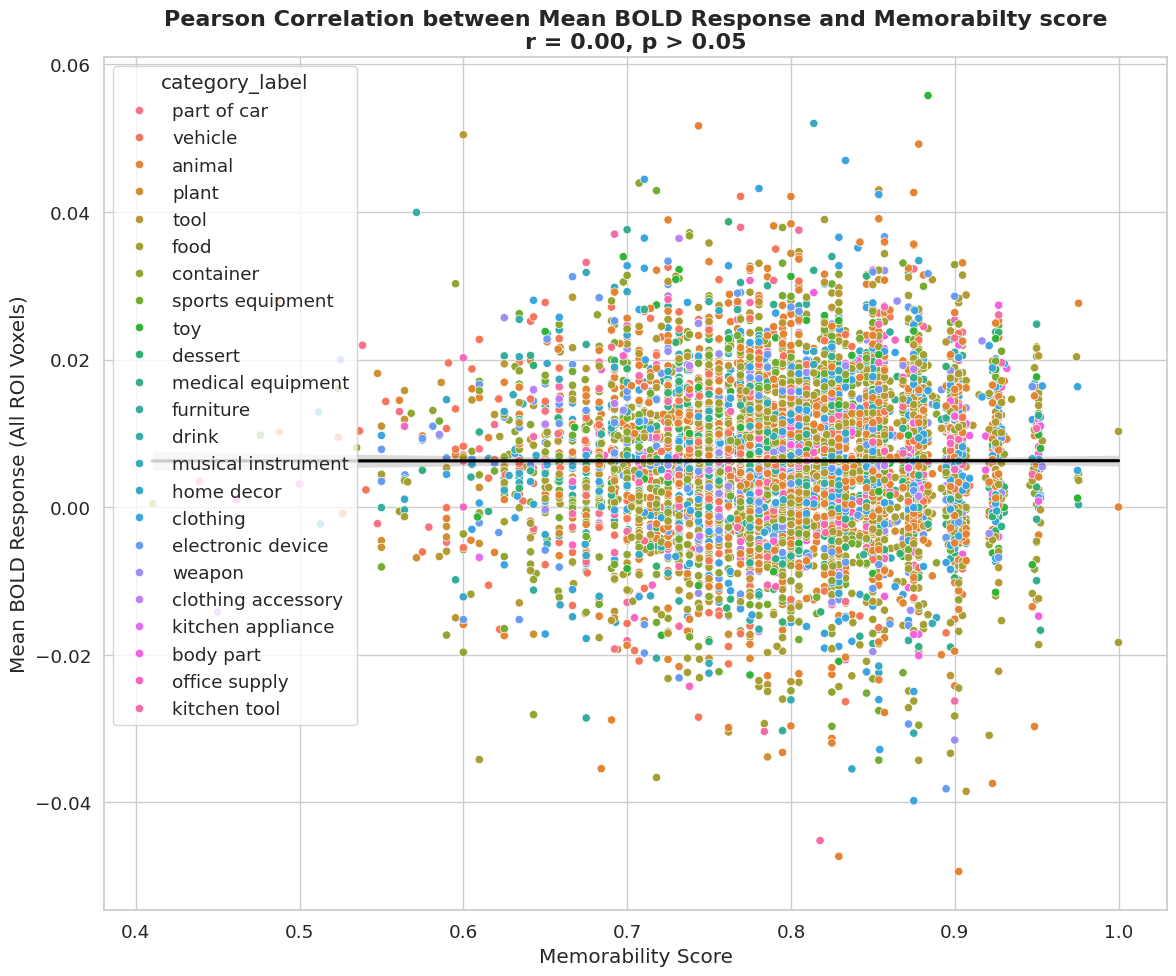

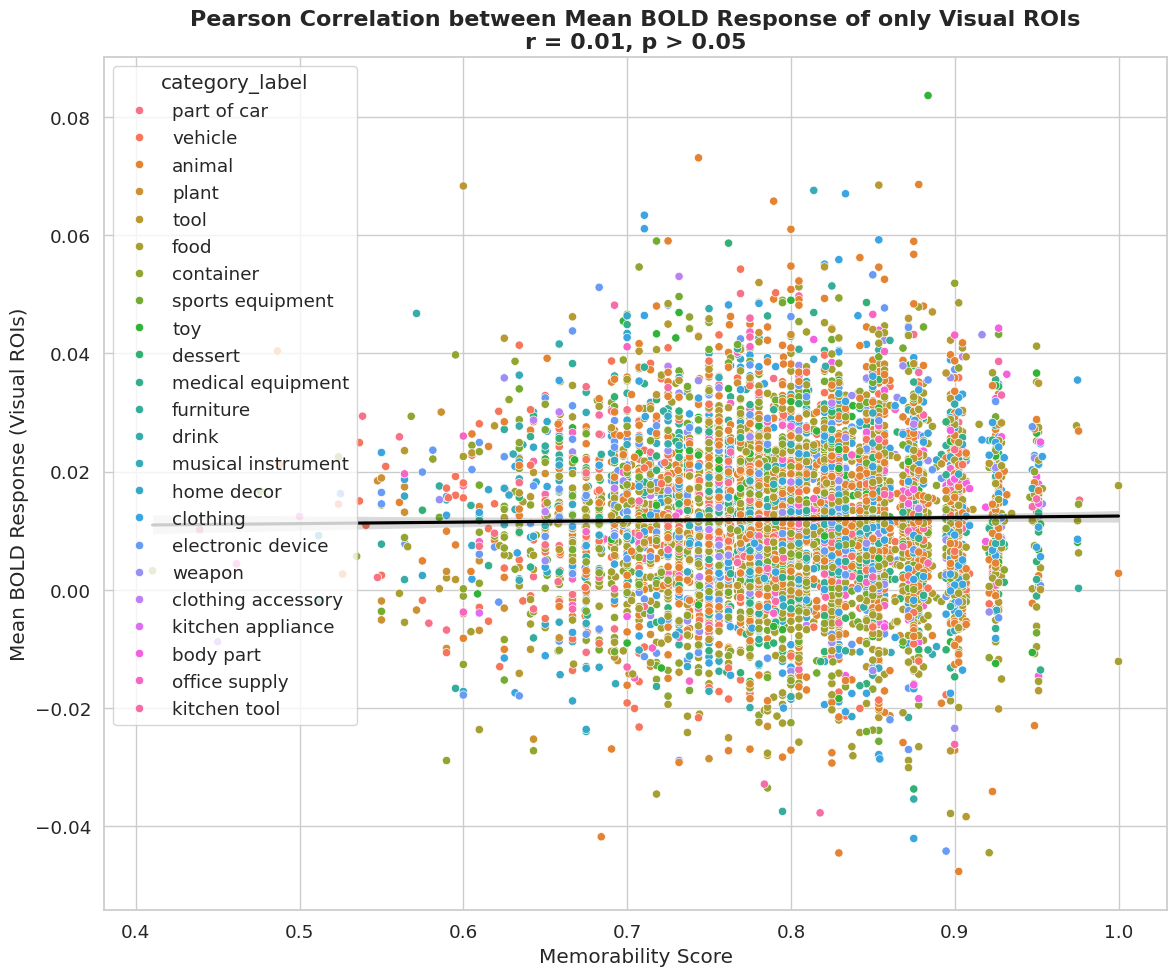

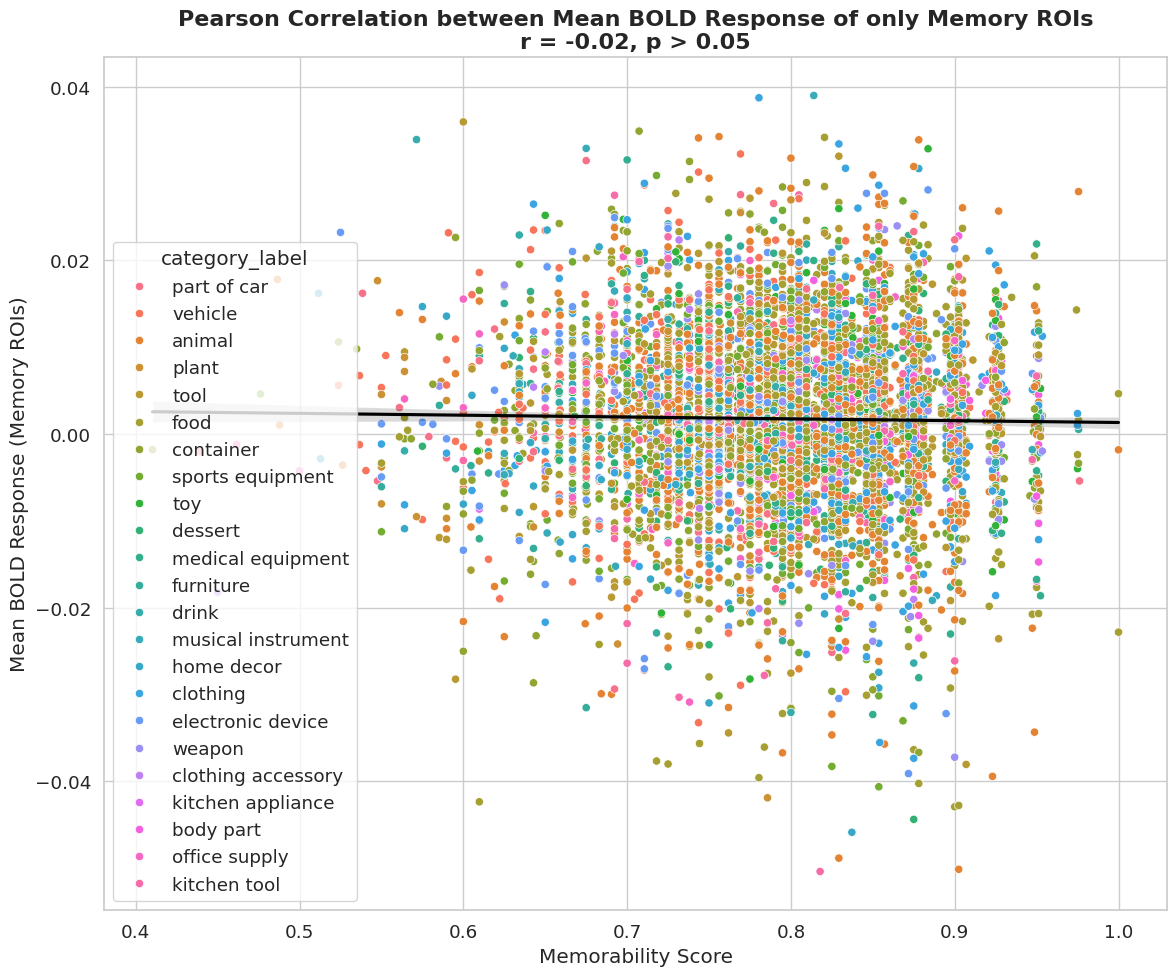

In [ ]:
#Plot 1: All ROI Voxels Mean Response vs Memorability

df_all = df_filtered.rename(columns={'memorability_score': 'cr'})
filtered_df = df_all.dropna(subset=['cr', 'AllVoxelsMean', 'category_label'])

plt.figure(figsize=(12, 10))
sns.scatterplot(x='cr', y='AllVoxelsMean', data=filtered_df, hue='category_label')
sns.regplot(x='cr', y='AllVoxelsMean', data=filtered_df, scatter=False, color='black')

corr, p_value = pearsonr(filtered_df['cr'], filtered_df['AllVoxelsMean'])
p_value_text = 'p > 0.05' if p_value > 0.05 else f'p = {p_value:.3f}'

plt.title(f'Pearson Correlation between Mean BOLD Response and Memorabilty score\nr = {corr:.2f}, {p_value_text}', fontsize=16, fontweight='bold')
plt.xlabel('Memorability Score')
plt.ylabel('Mean BOLD Response (All ROI Voxels)')
plt.tight_layout()
plt.show()


# Plot 2: Visual ROI Voxels Mean Response vs Memorability
df_visual = df_filtered.rename(columns={'memorability_score': 'cr'})
filtered_df = df_visual.dropna(subset=['cr', 'mean_visual_activation', 'category_label'])

plt.figure(figsize=(12, 10))
sns.scatterplot(x='cr', y='mean_visual_activation', data=filtered_df, hue='category_label')
sns.regplot(x='cr', y='mean_visual_activation', data=filtered_df, scatter=False, color='black')

corr, p_value = pearsonr(filtered_df['cr'], filtered_df['mean_visual_activation'])
p_value_text = 'p > 0.05' if p_value > 0.05 else f'p = {p_value:.3f}'

plt.title(f'Pearson Correlation between Mean BOLD Response of only Visual ROIs\nr = {corr:.2f}, {p_value_text}', fontsize=16, fontweight='bold')
plt.xlabel('Memorability Score')
plt.ylabel('Mean BOLD Response (Visual ROIs)')
plt.tight_layout()
plt.show()

# Plot 3: Memory ROI Voxels Mean Response vs Memorability
df_memory = df_filtered.rename(columns={'memorability_score': 'cr'})
filtered_df = df_memory.dropna(subset=['cr', 'mean_memory_activation', 'category_label'])

plt.figure(figsize=(12, 10))
sns.scatterplot(x='cr', y='mean_memory_activation', data=filtered_df, hue='category_label')
sns.regplot(x='cr', y='mean_memory_activation', data=filtered_df, scatter=False, color='black')

corr, p_value = pearsonr(filtered_df['cr'], filtered_df['mean_memory_activation'])
p_value_text = 'p > 0.05' if p_value > 0.05 else f'p = {p_value:.3f}'

plt.title(f'Pearson Correlation between Mean BOLD Response of only Memory ROIs\nr = {corr:.2f}, {p_value_text}', fontsize=16, fontweight='bold')
plt.xlabel('Memorability Score')
plt.ylabel('Mean BOLD Response (Memory ROIs)')
plt.tight_layout()
plt.show()





#Mean BOLD response vs Memorability score per ROI

In [ ]:
def plot_roi_vs_memorability(df, roi_list, title_prefix):
    # Drop rows with missing category or memorability score
    df = df.dropna(subset=['category_label', 'memorability_score'])

    # Rename for simplicity
    df = df.rename(columns={'memorability_score': 'cr'})

    # Prepare grid size (auto-fit square shape)
    n_rois = len(roi_list)
    n_cols = 3
    n_rows = (n_rois + n_cols - 1) // n_cols

    # Initialize plot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    # Plot each ROI
    for i, region in enumerate(roi_list):
        if region not in df.columns:
            continue
        corr, p_value = pearsonr(df['cr'], df[region])
        p_text = 'p > 0.05' if p_value > 0.05 else f'p = {p_value:.3f}'

        sns.scatterplot(x='cr', y=region, data=df, hue='category_label',
                        ax=axes[i], palette='tab20', legend=False)
        sns.regplot(x='cr', y=region, data=df, scatter=False, color='black', ax=axes[i])

        axes[i].set_title(f'{region}\nr = {corr:.2f}, {p_text}', fontweight='semibold')
        axes[i].set_xlabel('Memorability Score')
        axes[i].set_ylabel('Mean BOLD Response')

    # Remove unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'{title_prefix}: Memorability vs. BOLD Response per ROI', fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()



plot_roi_vs_memorability(df_filtered.copy(), visual_rois, 'Visual ROIs')
plot_roi_vs_memorability(df_filtered.copy(), memory_rois, 'Memory ROIs')



Output hidden; open in https://colab.research.google.com to view.

#Distribution of Memorability Scores Across Categories

In [ ]:
import plotly.express as px
import pandas as pd

# Compute mean memorability per category for hover info
category_means = filtered_df.groupby("category_label")["cr"].mean().round(2).reset_index()
category_means = category_means.rename(columns={"cr": "mean_memorability"})

# Merge means back into the main dataframe for hover info
df_with_hover = filtered_df.merge(category_means, on="category_label", how="left")

# Create interactive boxplot
fig = px.box(df_with_hover,
             x="category_label",
             y="cr",
             color="category_label",
             hover_data=["category_label", "mean_memorability"],
             points="all",
             title="Distribution of Memorability Scores Across Categories",
             labels={"cr": "Memorability Score", "category_label": "Category"})

# Rotate x-axis labels
fig.update_layout(
    xaxis_tickangle=-45,
    showlegend=False,
    height=600,
    width=1100
)

fig.show()


#Distribution of Memorability Scores Across Categories (Violin Plot)

<ipython-input-16-26ec9b33f4f7>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




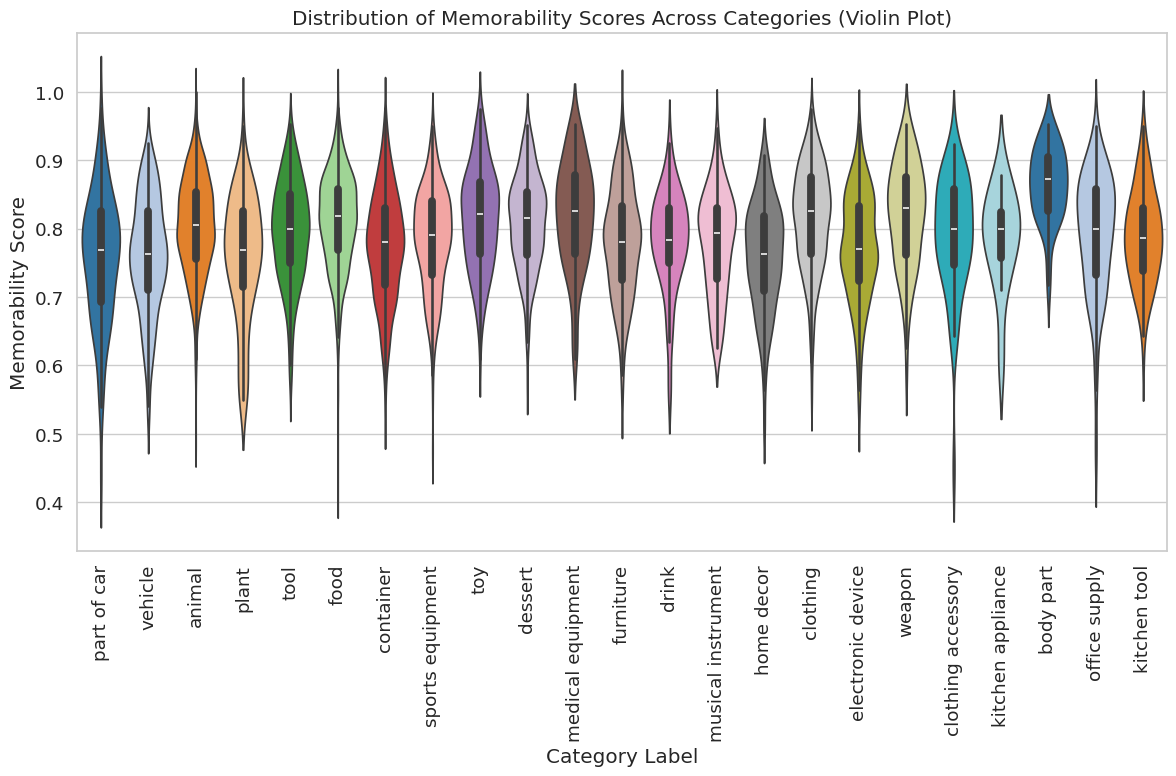

In [ ]:
# Create a violin plot to visualize the distribution of memorability scores across categories
plt.figure(figsize=(12, 8))
sns.violinplot(x='category_label', y='cr', data=filtered_df, palette='tab20')
plt.xticks(rotation=90)  # Rotate the category labels for better readability
plt.title('Distribution of Memorability Scores Across Categories (Violin Plot)')
plt.xlabel('Category Label')
plt.ylabel('Memorability Score')
plt.tight_layout()
plt.show()

#Correlation matrix for fMRI regions and memorability scores

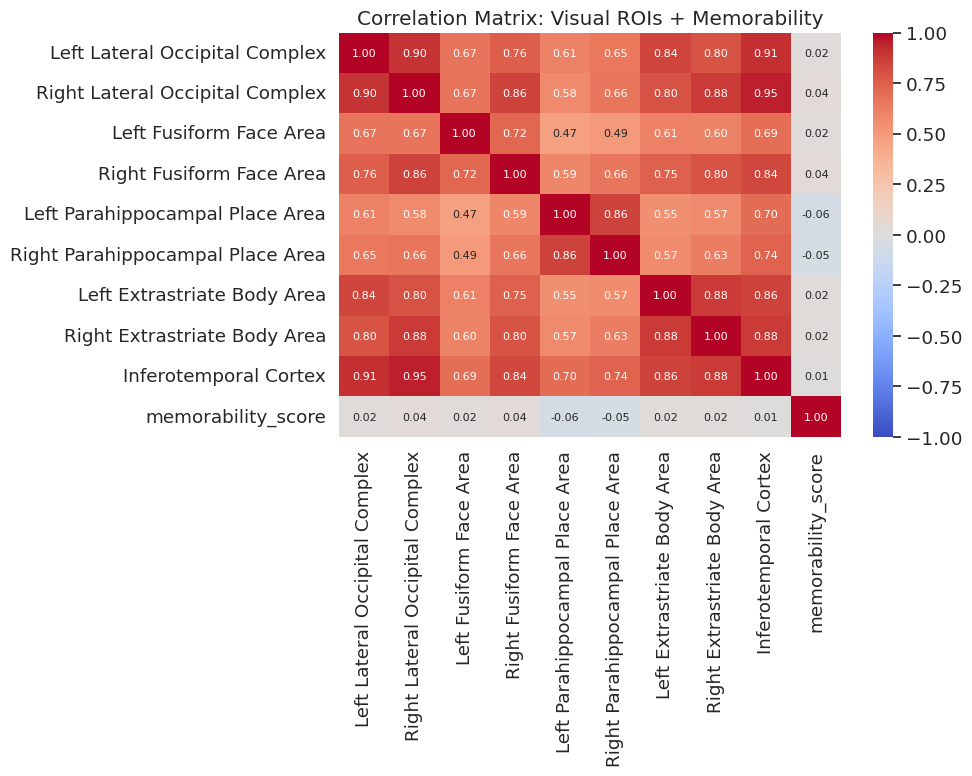

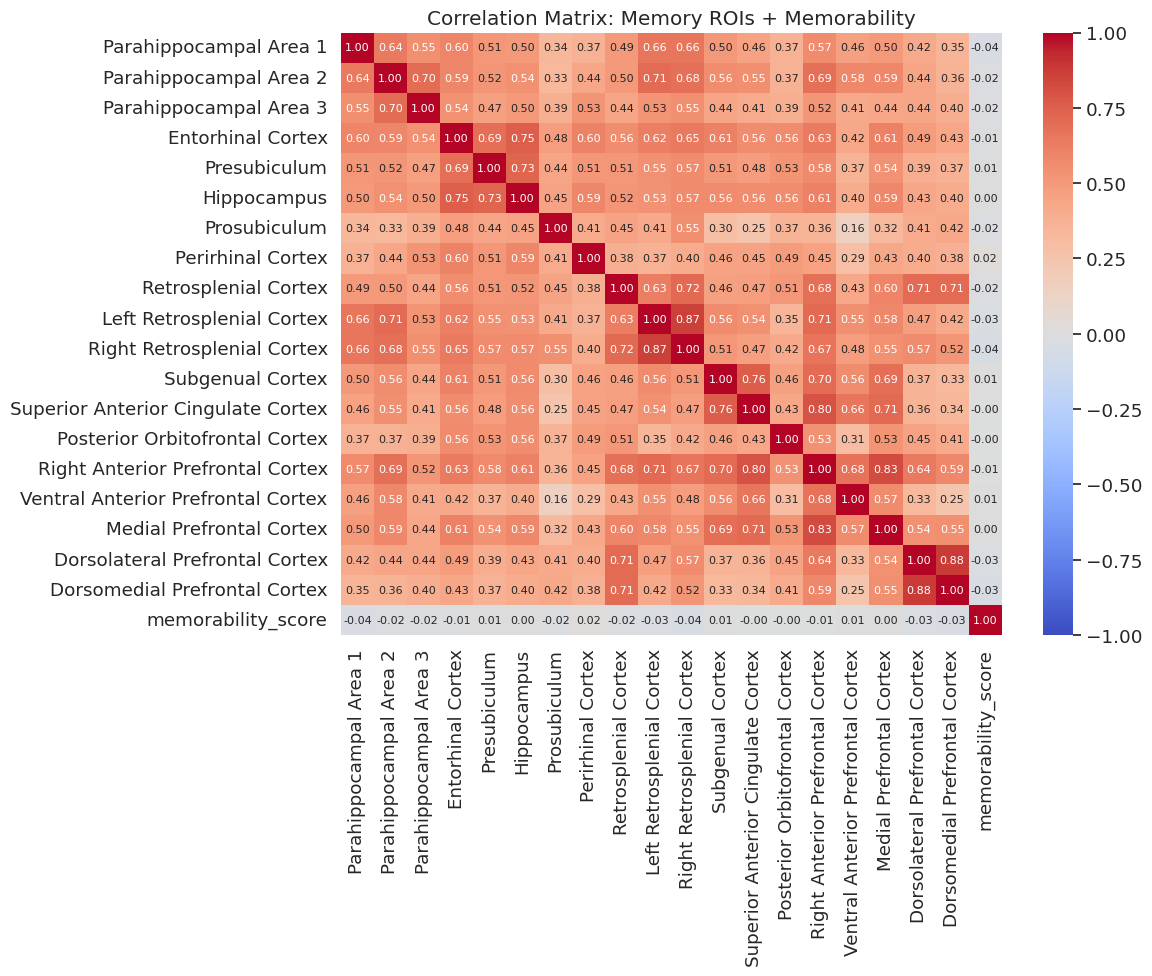

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# visual
# Add 'memorability_score' for correlation
visual_corr_df = df_visual_only[visual_roi_columns + ['memorability_score']].dropna()

# Compute correlation
corr_matrix_visual = visual_corr_df.corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_visual, annot=True,fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title("Correlation Matrix: Visual ROIs + Memorability")
plt.tight_layout()
plt.show()

# memory
# Add 'memorability_score' for correlation
memory_corr_df = df_memory_only[memory_roi_columns + ['memorability_score']].dropna()

# Compute correlation
corr_matrix_memory = memory_corr_df.corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_memory, annot=True,fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title("Correlation Matrix: Memory ROIs + Memorability")
plt.tight_layout()
plt.show()





# Category Checks

In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define groups of categories with similar sample sizes
category_groups = {
    "Living Things": ["animal", "plant", "body part"],
    "Food Related": ["food", "dessert", "drink"],
    "Tools & Equipment": ["tool", "kitchen tool", "sports equipment", "medical equipment"],
    "Vehicles & Devices": ["vehicle", "electronic device", "part of car"],
    "Home & Office Items": ["home decor", "furniture", "office supply", "kitchen appliance"]
}

category2_groups = {
    "Body Parts Shown": ["body part"],
    "Faces Shown": ["animal", "body part", ],  # Possible categories with faces
    "Objects Shown": [
        "clothing", "clothing accessory", "container", "dessert", "drink", "electronic device",
        "food", "furniture", "home decor", "kitchen tool", "medical equipment", "office supply",
        "part of car", "sports equipment", "tool", "vehicle", "weapon"
    ]
}


# Drop missing values in necessary columns
df = df.dropna(subset=['category_label', "memorability_score"])

def plot_groupwise_correlations(df, category_groups, roi_columns, group_type=""):
    df = df.dropna(subset=['category_label', 'memorability_score'])

    for group_name, categories in category_groups.items():
        filtered_df = df[df["category_label"].isin(categories)]
        if filtered_df.empty:
            print(f"Skipping {group_name}: No data available.")
            continue

        # Determine number of subplots based on ROIs
        n_rois = len(roi_columns)
        n_cols = 3
        n_rows = math.ceil(n_rois / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        # Set up color palette
        unique_categories = sorted(filtered_df["category_label"].unique())
        palette = sns.color_palette("tab10", len(unique_categories))
        color_map = dict(zip(unique_categories, palette))

        # Generate one temporary plot to get legend handles
        tmp_ax = fig.add_subplot(111)
        tmp_plot = sns.scatterplot(
            x='memorability_score', y=roi_columns[0], data=filtered_df,
            hue='category_label', palette=color_map, ax=tmp_ax, alpha=0.7
        )
        handles, labels = tmp_ax.get_legend_handles_labels()
        tmp_ax.remove()  # clean up dummy axis

        for i, roi in enumerate(roi_columns):
            if i >= len(axes):
                break

            corr, p = pearsonr(filtered_df['memorability_score'], filtered_df[roi])
            p_text = f'p = {p:.3f}' if p <= 0.05 else 'p > 0.05'

            sns.scatterplot(x='memorability_score', y=roi, data=filtered_df,
                            hue='category_label', palette=color_map, ax=axes[i], alpha=0.7, legend=False)

            sns.regplot(x='memorability_score', y=roi, data=filtered_df,
                        scatter=False, color='black', ax=axes[i])

            axes[i].set_title(f'{roi}\nr = {corr:.2f}, {p_text}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Memorability Score')
            axes[i].set_ylabel('BOLD Response')

        # Remove empty axes
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        # Shared legend
        fig.legend(handles, labels, title="Categories", loc='center left',
                   bbox_to_anchor=(1.02, 0.5), frameon=True)

        plt.suptitle(f'{group_type} - ROI Correlations: {group_name}', fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 0.98, 0.98])
        plt.show()



plot_groupwise_correlations(df_visual_only.copy(), category_groups, visual_roi_columns, "Visual ROIs")
plot_groupwise_correlations(df_visual_only.copy(), category2_groups, visual_roi_columns, "Visual ROIs")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# now for memory rois
plot_groupwise_correlations(df_memory_only.copy(), category_groups, memory_roi_columns, "Memory ROIs")
plot_groupwise_correlations(df_memory_only.copy(), category2_groups, memory_roi_columns, "Memory ROIs")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def compute_correlations(df, grouping_dict, roi_columns, grouping_name):
    results = []

    # Ensure score is called 'cr'
    df = df.rename(columns={'memorability_score': 'cr'})

    category_counts = df["category_label"].value_counts().to_dict()

    for group_name, categories in grouping_dict.items():
        filtered_df = df[df["category_label"].isin(categories)]
        sample_size = sum(category_counts.get(cat, 0) for cat in categories)

        if filtered_df.empty:
            continue

        for roi in roi_columns:
            valid = filtered_df[['cr', roi]].dropna()
            if len(valid) > 1:
                r, p = pearsonr(valid['cr'], valid[roi])
                results.append({
                    grouping_name: group_name,
                    "ROI": roi,
                    "Pearson r": r,
                    "p-value": p,
                    "Sample Size": sample_size
                })

    # Convert to DataFrame
    corr_df = pd.DataFrame(results)

    # Filter only significant p-values
    corr_df = corr_df[corr_df["p-value"] <= 0.05]

    # Sort results
    sorted_df = corr_df.sort_values(
        by=["p-value", "Pearson r"],
        ascending=[True, False],
        key=lambda x: x.abs() if x.name == "Pearson r" else x
    )

    return sorted_df


In [ ]:
# visual
visual_r_cat  = compute_correlations(df_visual_only.copy(), {c: [c] for c in df_visual_only["category_label"].unique()}, visual_roi_columns, "Category")
visual_r_group1 = compute_correlations(df_visual_only.copy(), category_groups, visual_roi_columns, "Category Group")
visual_r_group2 = compute_correlations(df_visual_only.copy(), category2_groups, visual_roi_columns, "Category2 Group")

display(visual_r_cat)
display(visual_r_group1)
display(visual_r_group2)


Category                               ROI  Pearson r   p-value  \
114              drink       Left Extrastriate Body Area  -0.357914  0.004288   
158             weapon  Right Parahippocampal Place Area  -0.242753  0.007300   
90   medical equipment    Left Lateral Occipital Complex  -0.204895  0.017990   
0          part of car    Left Lateral Occipital Complex   0.235623  0.020832   
95   medical equipment  Right Parahippocampal Place Area  -0.198350  0.022098   
83             dessert           Left Fusiform Face Area  -0.146901  0.029012   
189      office supply    Left Lateral Occipital Complex   0.192771  0.034143   
6          part of car       Left Extrastriate Body Area   0.211426  0.038654   
116              drink             Inferotemporal Cortex  -0.259563  0.041623   
129         home decor          Right Fusiform Face Area   0.145558  0.042859   
108              drink    Left Lateral Occipital Complex  -0.250759  0.049319   
110              drink           Left Fusiform Face Area  -0.250691  0.049382   

     Sample Size  
114           62  
158          121  
90           133  
0             96  
95           133  
83           221  
189          121  
6             96  
116           62  
129          194  
108           62  
110           62

Category Group                              ROI  Pearson r   p-value  \
36  Home & Office Items   Left Lateral Occipital Complex   0.111018  0.013179   
37  Home & Office Items  Right Lateral Occipital Complex   0.090254  0.044098   

    Sample Size  
36          498  
37          498

Category2 Group                               ROI  Pearson r   p-value  \
22   Objects Shown   Left Parahippocampal Place Area  -0.067093  0.000003   
23   Objects Shown  Right Parahippocampal Place Area  -0.053533  0.000187   
19   Objects Shown   Right Lateral Occipital Complex   0.032715  0.022483   

    Sample Size  
22         4866  
23         4866  
19         4866

In [ ]:
# memory

memory_r_cat  = compute_correlations(df_memory_only.copy(), {c: [c] for c in df_memory_only["category_label"].unique()}, memory_roi_columns, "Category")
memory_r_group1 = compute_correlations(df_memory_only.copy(), category_groups, memory_roi_columns, "Category Group")
memory_r_group2 = compute_correlations(df_memory_only.copy(), category2_groups, memory_roi_columns, "Category2 Group")

display(memory_r_cat)
display(memory_r_group1)
display(memory_r_group2)


Category                                 ROI  Pearson r  \
234              drink                        Prosubiculum  -0.503297   
246              drink       Dorsomedial Prefrontal Cortex  -0.394495   
324             weapon              Parahippocampal Area 2  -0.266832   
333             weapon          Right Retrosplenial Cortex  -0.259692   
242              drink    Right Anterior Prefrontal Cortex  -0.347126   
245              drink      Dorsolateral Prefrontal Cortex  -0.345711   
323             weapon              Parahippocampal Area 1  -0.246736   
215          furniture                        Prosubiculum  -0.201558   
233              drink                         Hippocampus  -0.330535   
236              drink                Retrosplenial Cortex  -0.329804   
207  medical equipment      Dorsolateral Prefrontal Cortex  -0.221387   
196  medical equipment                        Prosubiculum  -0.206313   
332             weapon           Left Retrosplenial Cortex  -0.213587   
244              drink            Medial Prefrontal Cortex  -0.297866   
191  medical equipment              Parahippocampal Area 2  -0.195568   
238              drink          Right Retrosplenial Cortex  -0.275549   
341             weapon       Dorsomedial Prefrontal Cortex  -0.195996   
173            dessert              Parahippocampal Area 3  -0.143989   
335             weapon  Superior Anterior Cingulate Cortex  -0.180470   

      p-value  Sample Size  
234  0.000031           62  
246  0.001510           62  
324  0.003091          121  
333  0.004021          121  
242  0.005707           62  
245  0.005921           62  
323  0.006367          121  
215  0.008204          171  
233  0.008694           62  
236  0.008852           62  
207  0.010440          133  
196  0.017193          133  
332  0.018659          121  
244  0.018707           62  
191  0.024074          133  
238  0.030183           62  
341  0.031200          121  
173  0.032389          221  
335  0.047607          121

Empty DataFrame
Columns: [Category Group, ROI, Pearson r, p-value, Sample Size]
Index: []

Category2 Group                             ROI  Pearson r   p-value  \
48   Objects Shown      Right Retrosplenial Cortex  -0.046963  0.001049   
56   Objects Shown   Dorsomedial Prefrontal Cortex  -0.037547  0.008808   
38   Objects Shown          Parahippocampal Area 1  -0.036730  0.010395   
47   Objects Shown       Left Retrosplenial Cortex  -0.032695  0.022564   
55   Objects Shown  Dorsolateral Prefrontal Cortex  -0.028993  0.043139   
45   Objects Shown               Perirhinal Cortex   0.028770  0.044773   

    Sample Size  
48         4866  
56         4866  
38         4866  
47         4866  
55         4866  
45         4866

In [ ]:
def plot_strongest_correlations(correlation_df, full_df, title, groupings, top_n=5, color="blue"):
    """
    Plot top N strongest significant correlations (Pearson r).

    Parameters:
    - correlation_df: DataFrame with correlation results (already filtered by p ≤ 0.05)
    - full_df: DataFrame with all stimulus-level data (e.g., df_visual_only)
    - title: Title string for the plot (e.g., "Visual ROIs – Category Group Level")
    - groupings: dict used for that level (e.g., category_groups or category2_groups)
    - top_n: number of plots to show
    - color: color for points
    """
    # Sort by absolute correlation value
    top_results = correlation_df.sort_values(by="Pearson r", key=abs, ascending=False).head(top_n)

    if top_results.empty:
        print(f"No significant correlations found for {title}.")
        return

    fig, axes = plt.subplots(len(top_results), figsize=(8, 5 * len(top_results)))
    if len(top_results) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, top_results.iterrows()):
        # Identify group column (Category, Category Group, Category2 Group)
        group_column = next(col for col in ["Category", "Category Group", "Category2 Group"] if col in row)
        group_value = row[group_column]
        roi = row["ROI"]

        # Subset data
        if group_column == "Category":
            plot_df = full_df[full_df["category_label"] == group_value]
        else:
            category_list = groupings.get(group_value, [])
            plot_df = full_df[full_df["category_label"].isin(category_list)]

        valid = plot_df[['memorability_score', roi]].dropna()

        if valid.empty:
            ax.set_visible(False)
            continue

        # Plot
        sns.scatterplot(x="memorability_score", y=roi, data=valid, ax=ax, color=color, alpha=0.7)
        sns.regplot(x="memorability_score", y=roi, data=valid, ax=ax, scatter=False, color="black")

        ax.set_title(f"{group_value} - {roi}\n r = {row['Pearson r']:.2f}, p = {row['p-value']:.3f}")
        ax.set_xlabel("Memorability Score")
        ax.set_ylabel("ROI Response")

    plt.suptitle(f"Top {top_n} Significant Correlations – {title}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Example Usage (Visual ROIs)
plot_strongest_correlations(visual_r_cat, df_visual_only, "Visual ROIs – Category Level", {}, color="blue")
plot_strongest_correlations(visual_r_group1, df_visual_only, "Visual ROIs – Category Group Level", category_groups, color="green")
plot_strongest_correlations(visual_r_group2, df_visual_only, "Visual ROIs – Category2 Group Level", category2_groups, color="purple")

plot_strongest_correlations(memory_r_cat, df_memory_only, "Memory ROIs – Category Level", {}, color="blue")
plot_strongest_correlations(memory_r_group1, df_memory_only, "Memory ROIs – Category Group Level", category_groups, color="green")
plot_strongest_correlations(memory_r_group2, df_memory_only, "Memory ROIs – Category2 Group Level", category2_groups, color="purple")


Output hidden; open in https://colab.research.google.com to view.

check for calsses- mean and range and std
like for monkey - the 10 images what is the dist score. mayve well take only stable classess

Mean Memorability  STD Memorability  Range Memorability
concept                                                                  
acorn                      0.775878          0.115283            0.299101
airbag                     0.783499          0.102759            0.346053
aircraft_carrier           0.743992          0.096988            0.363415
airplane                   0.790564          0.047890            0.138837
alligator                  0.836935          0.033706            0.114286
...                             ...               ...                 ...
wrapping_paper             0.780428          0.096571            0.315018
wrench                     0.831694          0.080249            0.226219
yo-yo                      0.806218          0.059516            0.195270
zebra                      0.808553          0.075999            0.224050
zucchini                   0.830864          0.036411            0.129712

[720 rows x 3 columns]

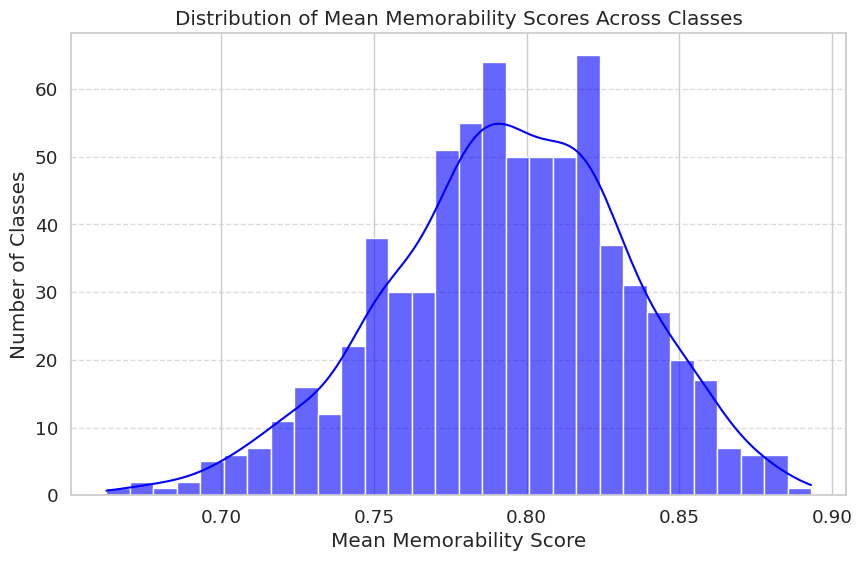

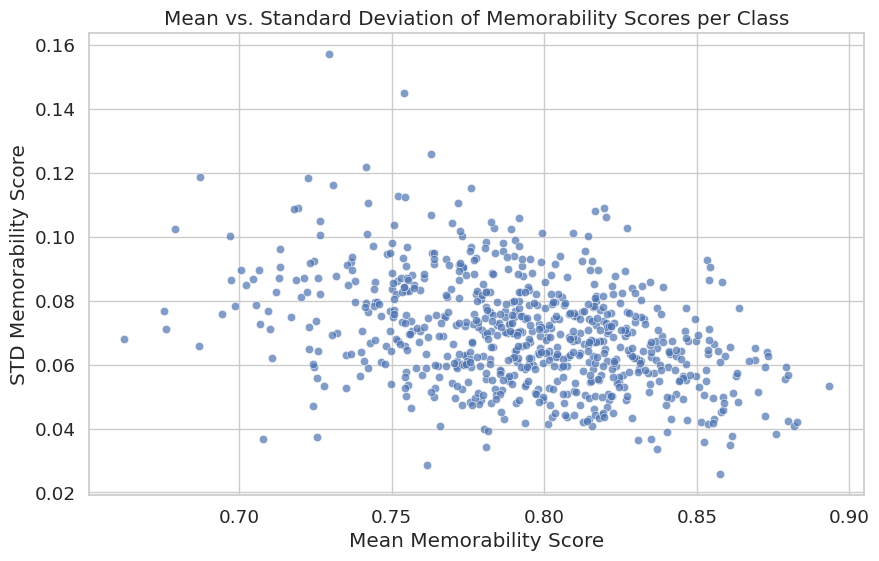

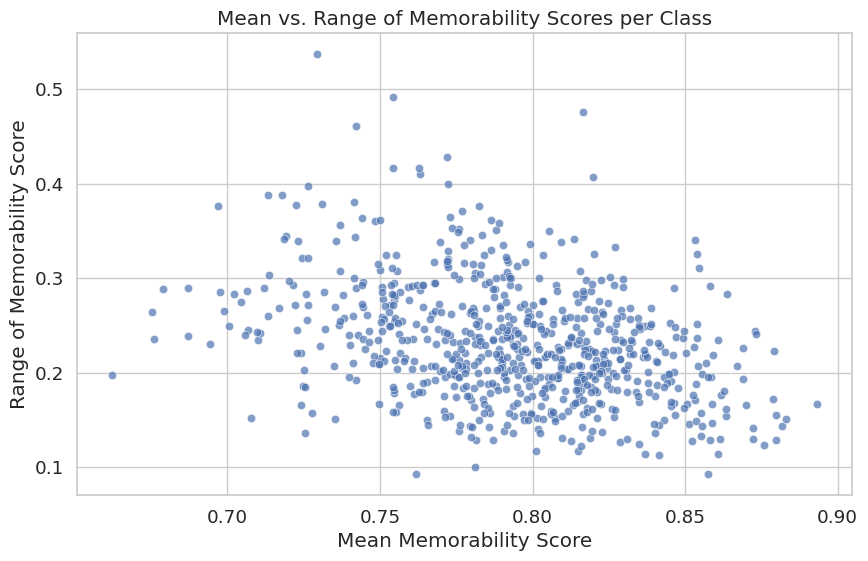

In [ ]:
# Group by class (concept) and compute memorability statistics
class_memorability_stats = df.groupby("concept")["memorability_score"].agg(['mean', 'std', lambda x: x.max() - x.min()])
class_memorability_stats.columns = ["Mean Memorability", "STD Memorability", "Range Memorability"]

# Display the computed class-level memorability statistics
display(class_memorability_stats)

# Plot memorability distribution across classes
plt.figure(figsize=(10, 6))
sns.histplot(class_memorability_stats["Mean Memorability"], bins=30, kde=True, color="blue", alpha=0.6)
plt.title("Distribution of Mean Memorability Scores Across Classes")
plt.xlabel("Mean Memorability Score")
plt.ylabel("Number of Classes")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Scatter plot: Mean vs. Standard Deviation of Memorability Scores per Class
plt.figure(figsize=(10, 6))
sns.scatterplot(x=class_memorability_stats["Mean Memorability"], y=class_memorability_stats["STD Memorability"], alpha=0.7)
plt.title("Mean vs. Standard Deviation of Memorability Scores per Class")
plt.xlabel("Mean Memorability Score")
plt.ylabel("STD Memorability Score")
plt.grid(True)
plt.show()

# Scatter plot: Mean vs. Range of Memorability Scores per Class
plt.figure(figsize=(10, 6))
sns.scatterplot(x=class_memorability_stats["Mean Memorability"], y=class_memorability_stats["Range Memorability"], alpha=0.7)
plt.title("Mean vs. Range of Memorability Scores per Class")
plt.xlabel("Mean Memorability Score")
plt.ylabel("Range of Memorability Score")
plt.grid(True)
plt.show()


Mean Memorability  STD Memorability  Range Memorability
concept                                                                  
airbag                     0.783499          0.102759            0.346053
aircraft_carrier           0.743992          0.096988            0.363415
airplane                   0.790564          0.047890            0.138837
anvil                      0.753291          0.073250            0.271777
apple                      0.826559          0.089204            0.293290
...                             ...               ...                 ...
whisk                      0.827655          0.076190            0.257692
wine                       0.791149          0.069109            0.275000
wire_cutters               0.749685          0.064188            0.208974
wrench                     0.831694          0.080249            0.226219
zucchini                   0.830864          0.036411            0.129712

[401 rows x 3 columns]

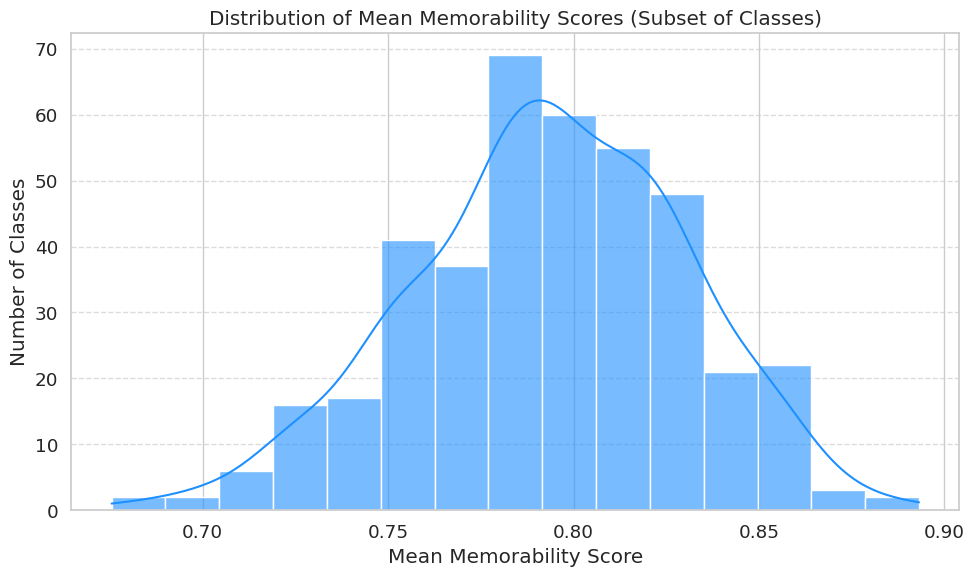

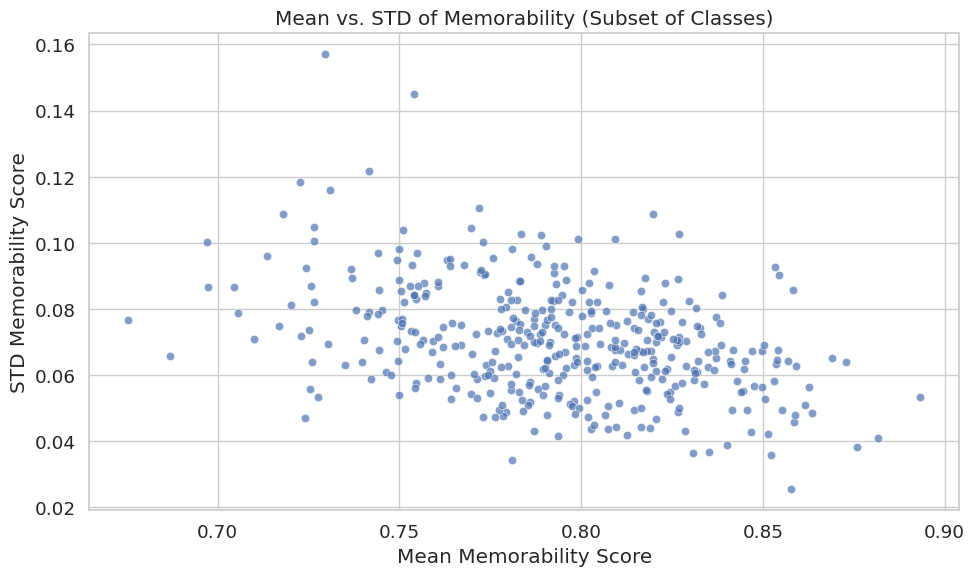

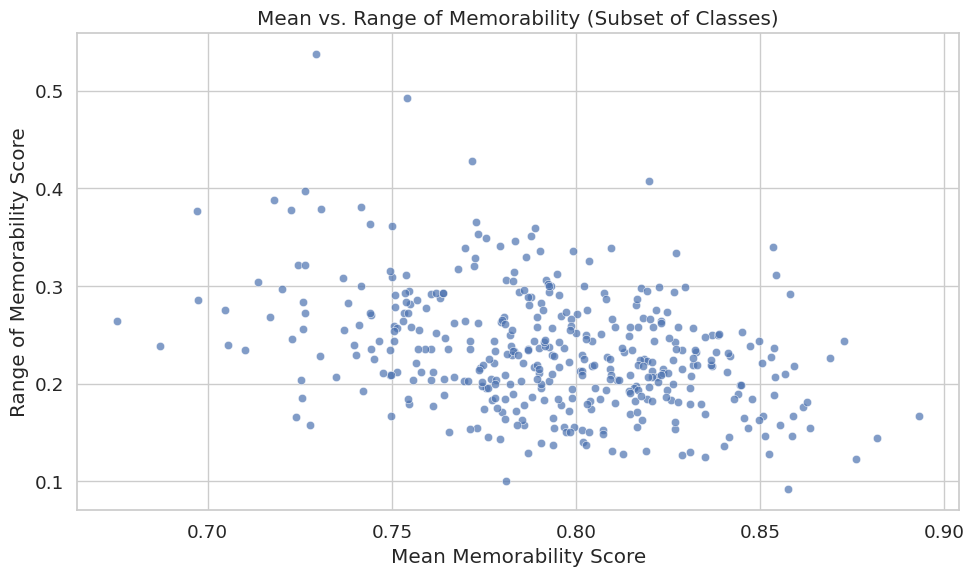

In [ ]:
# Choose the grouping (can be category_groups or category2_groups)
selected_group = category2_groups["Objects Shown"]  # Example: only use "Living Things"
# Or to include all groups together:
# selected_categories = sum(category_groups.values(), [])  # Flatten all categories across groups

# Filter df to only include categories in the selected group
filtered_df = df[df["category_label"].isin(selected_group)].copy()

# Group by concept and compute memorability stats
class_memorability_stats = filtered_df.groupby("concept")["memorability_score"].agg([
    'mean',
    'std',
    lambda x: x.max() - x.min()
]).rename(columns={
    "mean": "Mean Memorability",
    "std": "STD Memorability",
    "<lambda_0>": "Range Memorability"
})

# Display stats
display(class_memorability_stats)

# Plot histogram of mean memorability
plt.figure(figsize=(10, 6))
sns.histplot(class_memorability_stats["Mean Memorability"], bins=15, kde=True, color="dodgerblue", alpha=0.6)
plt.title("Distribution of Mean Memorability Scores (Subset of Classes)")
plt.xlabel("Mean Memorability Score")
plt.ylabel("Number of Classes")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Mean vs STD
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=class_memorability_stats["Mean Memorability"],
    y=class_memorability_stats["STD Memorability"],
    alpha=0.7
)
plt.title("Mean vs. STD of Memorability (Subset of Classes)")
plt.xlabel("Mean Memorability Score")
plt.ylabel("STD Memorability Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Mean vs Range
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=class_memorability_stats["Mean Memorability"],
    y=class_memorability_stats["Range Memorability"],
    alpha=0.7
)
plt.title("Mean vs. Range of Memorability (Subset of Classes)")
plt.xlabel("Mean Memorability Score")
plt.ylabel("Range of Memorability Score")
plt.grid(True)
plt.tight_layout()
plt.show()


# Yarden's grouped by to human score

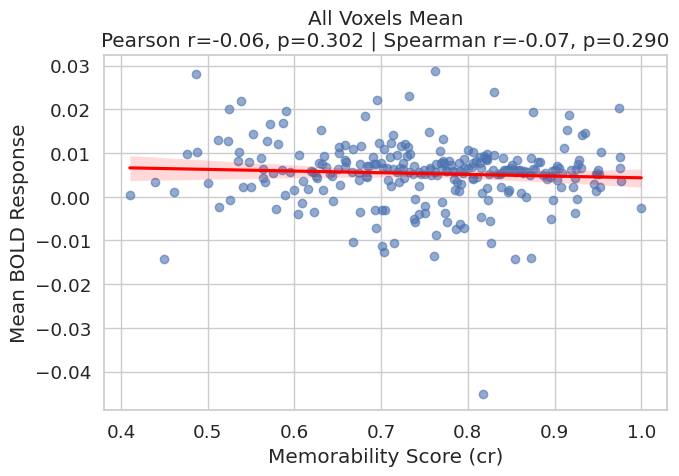

6517


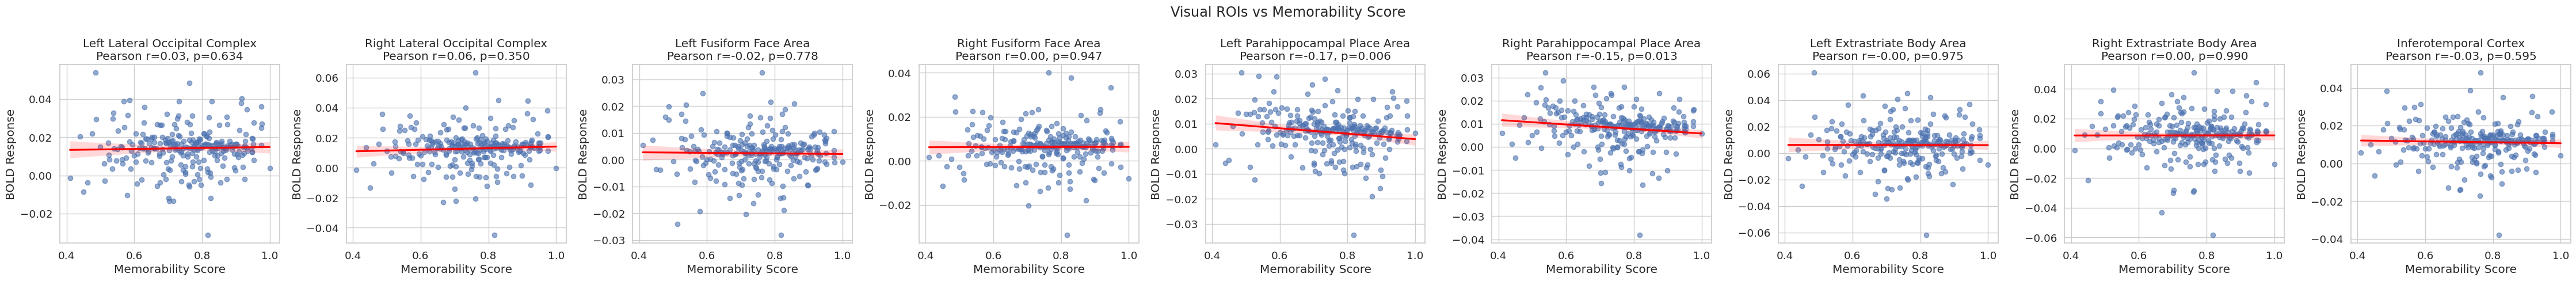

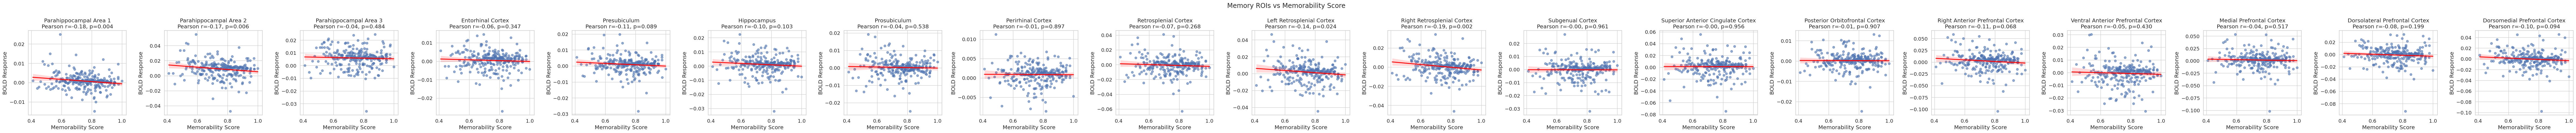

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Simulated minimal structure for demonstration purposes
# You already have:
# df_filtered["AllVoxelsMean"]
# df_visual_only and df_memory_only with memorability_score (cr) and ROI columns

# Group by memorability score and calculate mean responses
grouped_all = df_filtered.groupby("memorability_score", as_index=False)[["AllVoxelsMean"]].mean().dropna()
grouped_visual = df_visual_only.groupby("memorability_score", as_index=False).mean(numeric_only=True).dropna()
grouped_memory = df_memory_only.groupby("memorability_score", as_index=False).mean(numeric_only=True).dropna()

# Function to calculate correlation and return results
def compute_corr(x, y):
    pearson_r, pearson_p = pearsonr(x, y)
    spearman_r, spearman_p = spearmanr(x, y)
    return pearson_r, pearson_p, spearman_r, spearman_p

# Compute correlations for AllVoxelsMean
all_r, all_p, all_s_r, all_s_p = compute_corr(grouped_all["memorability_score"], grouped_all["AllVoxelsMean"])

# Visual plot for AllVoxelsMean
plt.figure(figsize=(7, 5))
sns.regplot(x="memorability_score", y="AllVoxelsMean", data=grouped_all, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title(f"All Voxels Mean\nPearson r={all_r:.2f}, p={all_p:.3f} | Spearman r={all_s_r:.2f}, p={all_s_p:.3f}")
plt.xlabel("Memorability Score (cr)")
plt.ylabel("Mean BOLD Response")
plt.tight_layout()
plt.grid(True)
plt.show()


# Plot for Visual ROIs
fig, axes = plt.subplots(1, len(grouped_visual.columns) - 1, figsize=(5 * (len(grouped_visual.columns) - 1), 5))
for i, roi in enumerate(grouped_visual.columns[1:]):
    r, p, sr, sp = compute_corr(grouped_visual["memorability_score"], grouped_visual[roi])
    sns.regplot(x="memorability_score", y=roi, data=grouped_visual, ax=axes[i], scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
    axes[i].set_title(f"{roi}\nPearson r={r:.2f}, p={p:.3f}")
    axes[i].set_xlabel("Memorability Score")
    axes[i].set_ylabel("BOLD Response")
plt.suptitle("Visual ROIs vs Memorability Score")
plt.tight_layout()
plt.show()

# Plot for Memory ROIs
fig, axes = plt.subplots(1, len(grouped_memory.columns) - 1, figsize=(5 * (len(grouped_memory.columns) - 1), 5))
for i, roi in enumerate(grouped_memory.columns[1:]):
    r, p, sr, sp = compute_corr(grouped_memory["memorability_score"], grouped_memory[roi])
    sns.regplot(x="memorability_score", y=roi, data=grouped_memory, ax=axes[i], scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
    axes[i].set_title(f"{roi}\nPearson r={r:.2f}, p={p:.3f}")
    axes[i].set_xlabel("Memorability Score")
    axes[i].set_ylabel("BOLD Response")
plt.suptitle("Memory ROIs vs Memorability Score")
plt.tight_layout()
plt.show()




# Distribution before grouping
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered["cr"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Memorability Scores (Original)")
plt.xlabel("Memorability Score")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Distribution after grouping (unique values in df_grouped_memory)
plt.figure(figsize=(10, 5))
sns.histplot(df_grouped_memory["cr"], bins=30, kde=True, color="salmon")
plt.title("Distribution of Memorability Scores (Grouped - Memory ROIs)")
plt.xlabel("Memorability Score")
plt.ylabel("Number of Aggregated Bins")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# We will use df_grouped_all which contains the grouped version by memorability score
plt.figure(figsize=(10, 5))
sns.histplot(df_grouped_all["cr"], bins=30, kde=True, color="salmon")
plt.title("Distribution of Memorability Scores (Grouped - All Voxels)")
plt.xlabel("Memorability Score")
plt.ylabel("Number of Aggregated Bins")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
